# Palmer penguins in R

## Content
1. Import libraries and prepare data
   * Load and view data
   * Missing values
   * Divide into train/valiation
2. Data: Understanding and visualization
   * Pairplot
   * Box plot
   * Correlation matrix
3. Feature analysis
   * Decision tree
   * RFECV
4. Modeling
   * Random forest using all features
   * Random forest on reduced model
   * Random forest and SVM on even further reduced model
   
# 1. Preparation of data

In [2]:
options(warn=-1)
library(palmerpenguins)
library(ggplot2)
library(GGally)
library(lattice)
library(caret)
library(randomForest)
library(tree)
library(explore)
library(tidyverse)
library(e1071)

## 1.1 Load and view data
#### We start by loading the data we want to analyze

In [3]:
data <- penguins 
dataset <- penguins
head(dataset)

dataset[, c('sex', 'island')] <- sapply(dataset[, c('sex', 'island')], unclass)
cat('Classes in dataset: '); cat(crayon::bold(levels(dataset$species)), sep = ' & ')

species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>,<int>
Adelie,Torgersen,39.1,18.7,181,3750,male,2007
Adelie,Torgersen,39.5,17.4,186,3800,female,2007
Adelie,Torgersen,40.3,18.0,195,3250,female,2007
Adelie,Torgersen,NA,NA,NA,NA,NA,2007
Adelie,Torgersen,36.7,19.3,193,3450,female,2007
Adelie,Torgersen,39.3,20.6,190,3650,male,2007


Classes in dataset: Adelie & Chinstrap & Gentoo

## 1.2 Missing values

#### We observe that our dataset contains a few missing values. We decide to remove them, but we could also try replacing the missing values with mean, median, mode or try kNN imputer.

In [4]:
cat('Dimension of dataset:', dim(dataset)[1], 'x', dim(dataset)[2], '\n')
dataset <- na.omit(dataset)
cat('Dimension of dataset after removing missing values:', dim(dataset)[1], 'x', dim(dataset)[2])

Dimension of dataset: 344 x 8 
Dimension of dataset after removing missing values: 333 x 8

## 1.3 Split data into train/validation

#### We split the dataset into a training set and a validation set. We use a ratio of 0.75.

In [5]:
Y = dataset$species
Y_loc = 1
x_loc = 2:8

validation_index <- createDataPartition(dataset$species, p= 0.75, list = FALSE)
validation <- dataset[-validation_index,]
validation = data.frame(validation)
dataset <- dataset[validation_index,]

# 2. Visualization the dataset

### 2.1 Pairplot

#### From the pairplot, we can see that the diagonal plots (i.e., the distribution plots) shows some interesting patterns. 

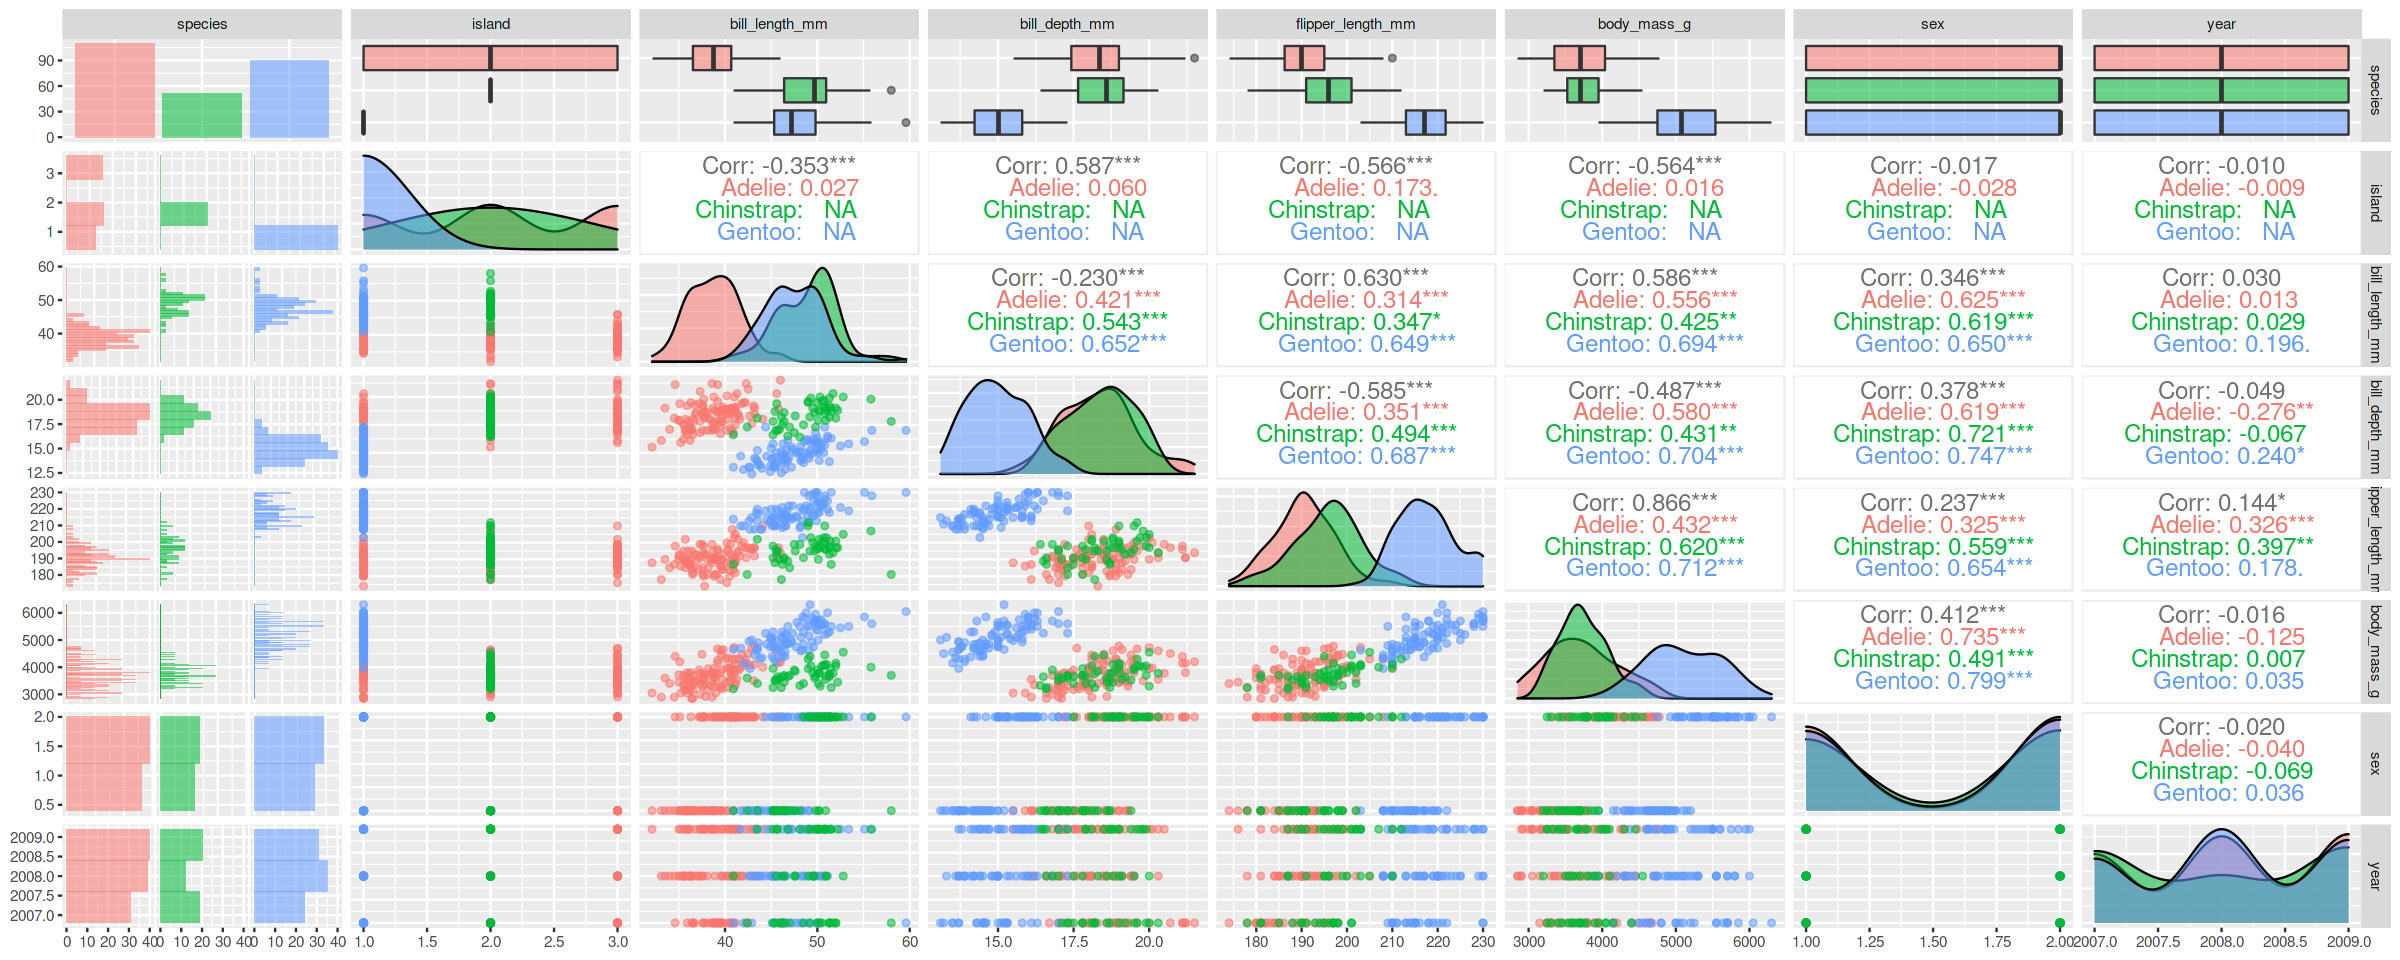

In [6]:
data(tips, package="reshape")
options(repr.plot.width=20, repr.plot.height=8)
ggpairs(dataset, lower=list(combo=wrap("facethist", binwidth=0.8)),
        columns = 1:length(dataset),
        aes(color = species,
            alpha = 0.5),
       upper = list(continuous = wrap("cor", size = 5)))

## 2.2 Boxplot

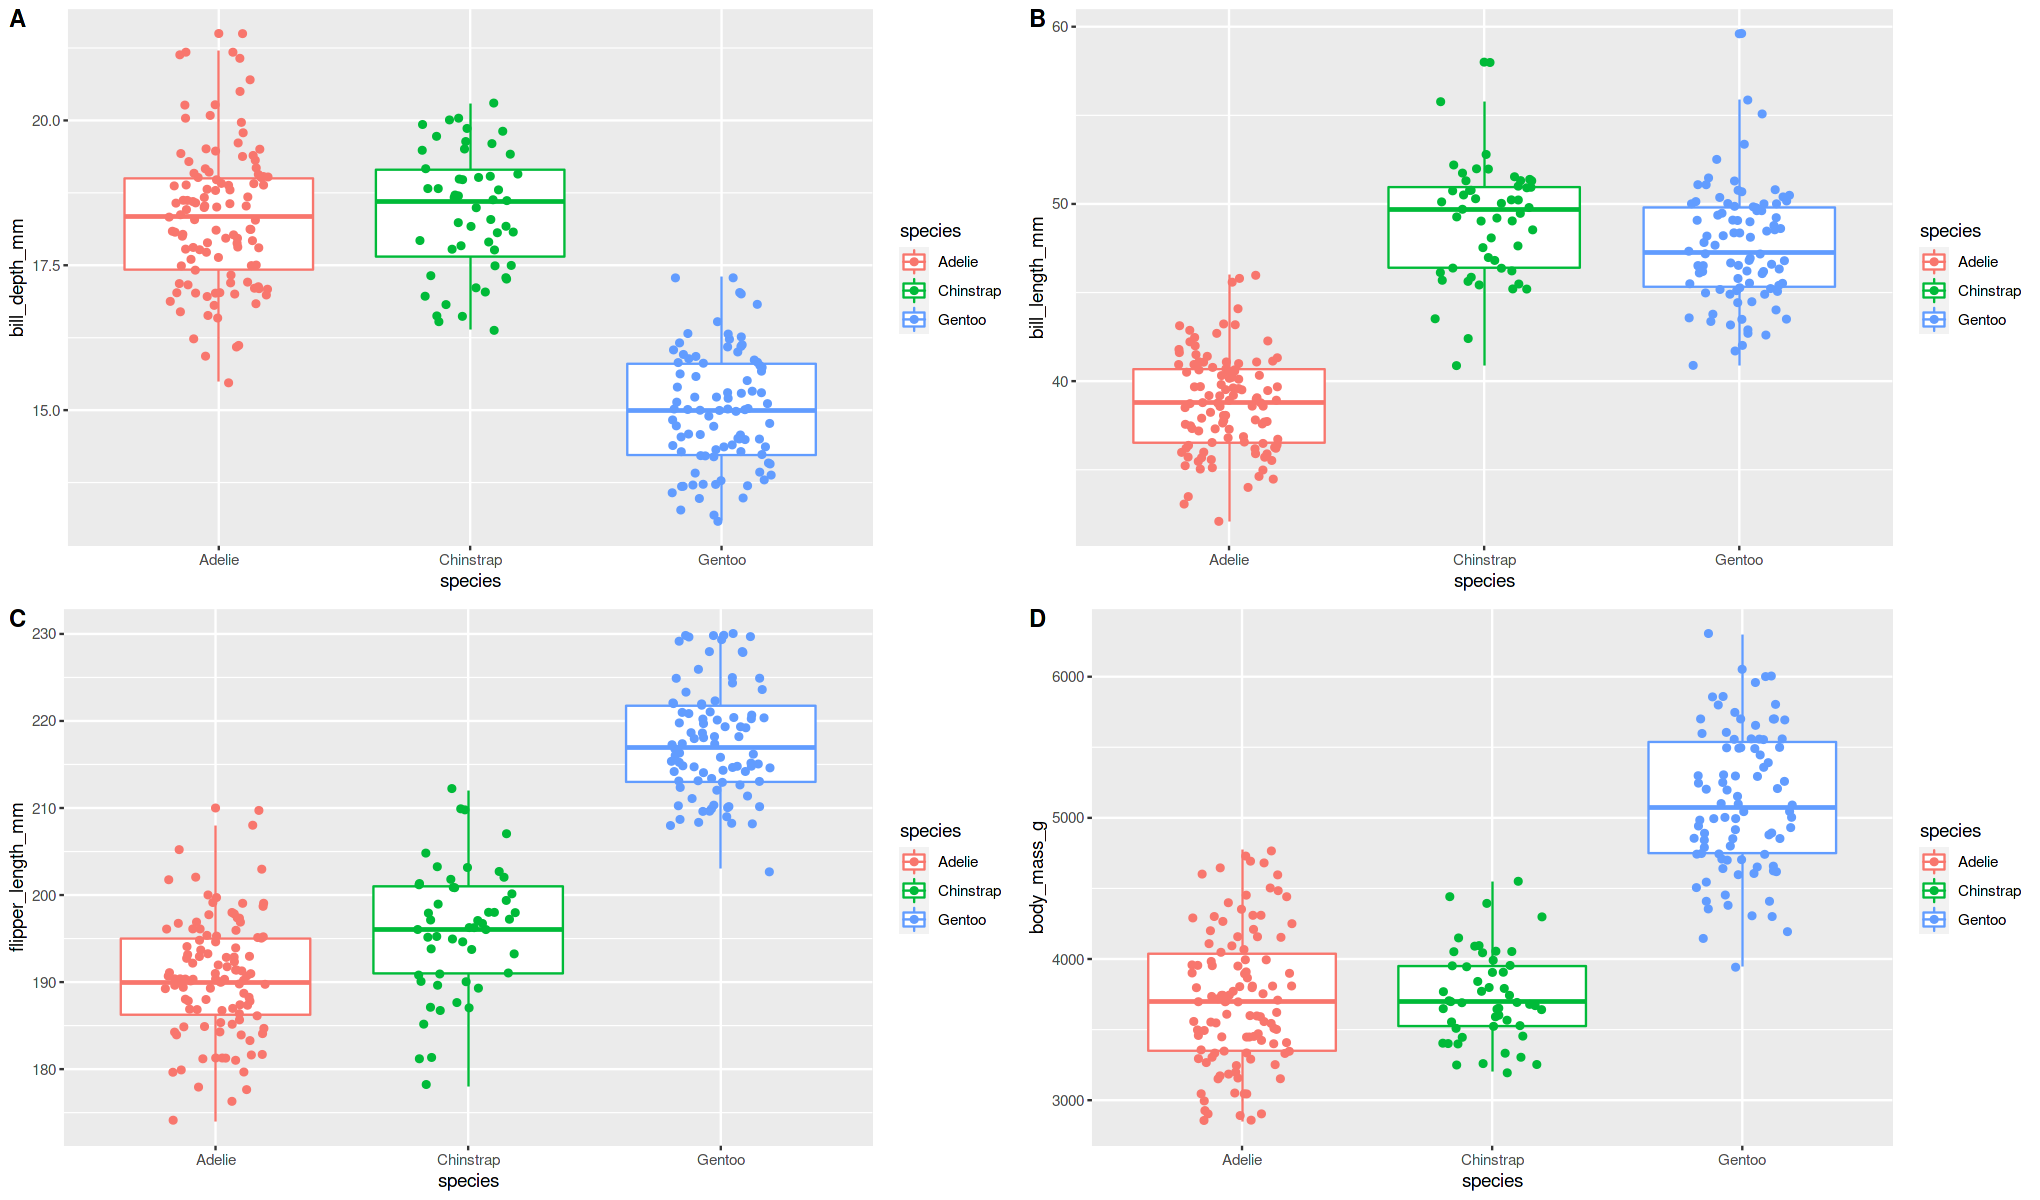

In [7]:
library(cowplot)
options(repr.plot.width=17, repr.plot.height=10)
plot1 <- ggplot(dataset) +
  aes(x = species, y = bill_depth_mm, color = species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

plot2 <- ggplot(dataset) +
  aes(x = species, y = bill_length_mm, color = species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

plot3 <- ggplot(dataset) +
  aes(x = species, y = flipper_length_mm, color = species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

plot4 <- ggplot(dataset) +
  aes(x = species, y = body_mass_g, color = species) +
  geom_boxplot() +
  geom_jitter(position = position_jitter(0.2))

plot_grid(plot1,plot2,plot3,plot4, labels = "AUTO")

## 2.3 Correlation matrix


In [8]:
dataset %>%
    select_if(is.numeric) %>%
    cor()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
island,1.000000000,-0.35266091,0.58736592,-0.5662532,-0.56416834,-0.01698148,-0.009789065
bill_length_mm,-0.352660905,1.00000000,-0.23044001,0.6304263,0.58589656,0.34630106,0.030341752
bill_depth_mm,0.587365919,-0.23044001,1.00000000,-0.5851947,-0.48656775,0.37825514,-0.049047692
flipper_length_mm,-0.566253198,0.63042630,-0.58519466,1.0000000,0.86646679,0.23703485,0.143635845
body_mass_g,-0.564168344,0.58589656,-0.48656775,0.8664668,1.00000000,0.41241024,-0.016442734
sex,-0.016981483,0.34630106,0.37825514,0.2370349,0.41241024,1.00000000,-0.019838347
year,-0.009789065,0.03034175,-0.04904769,0.1436358,-0.01644273,-0.01983835,1.000000000


# 3. Feature analysis

#### We now use RFECV and a decision tree to investigate which of our features are important. 


## 3.1 Decision tree
#### From the decision tree, we see that flipper length, bill length, bill depth, island and body mass are considered important. 

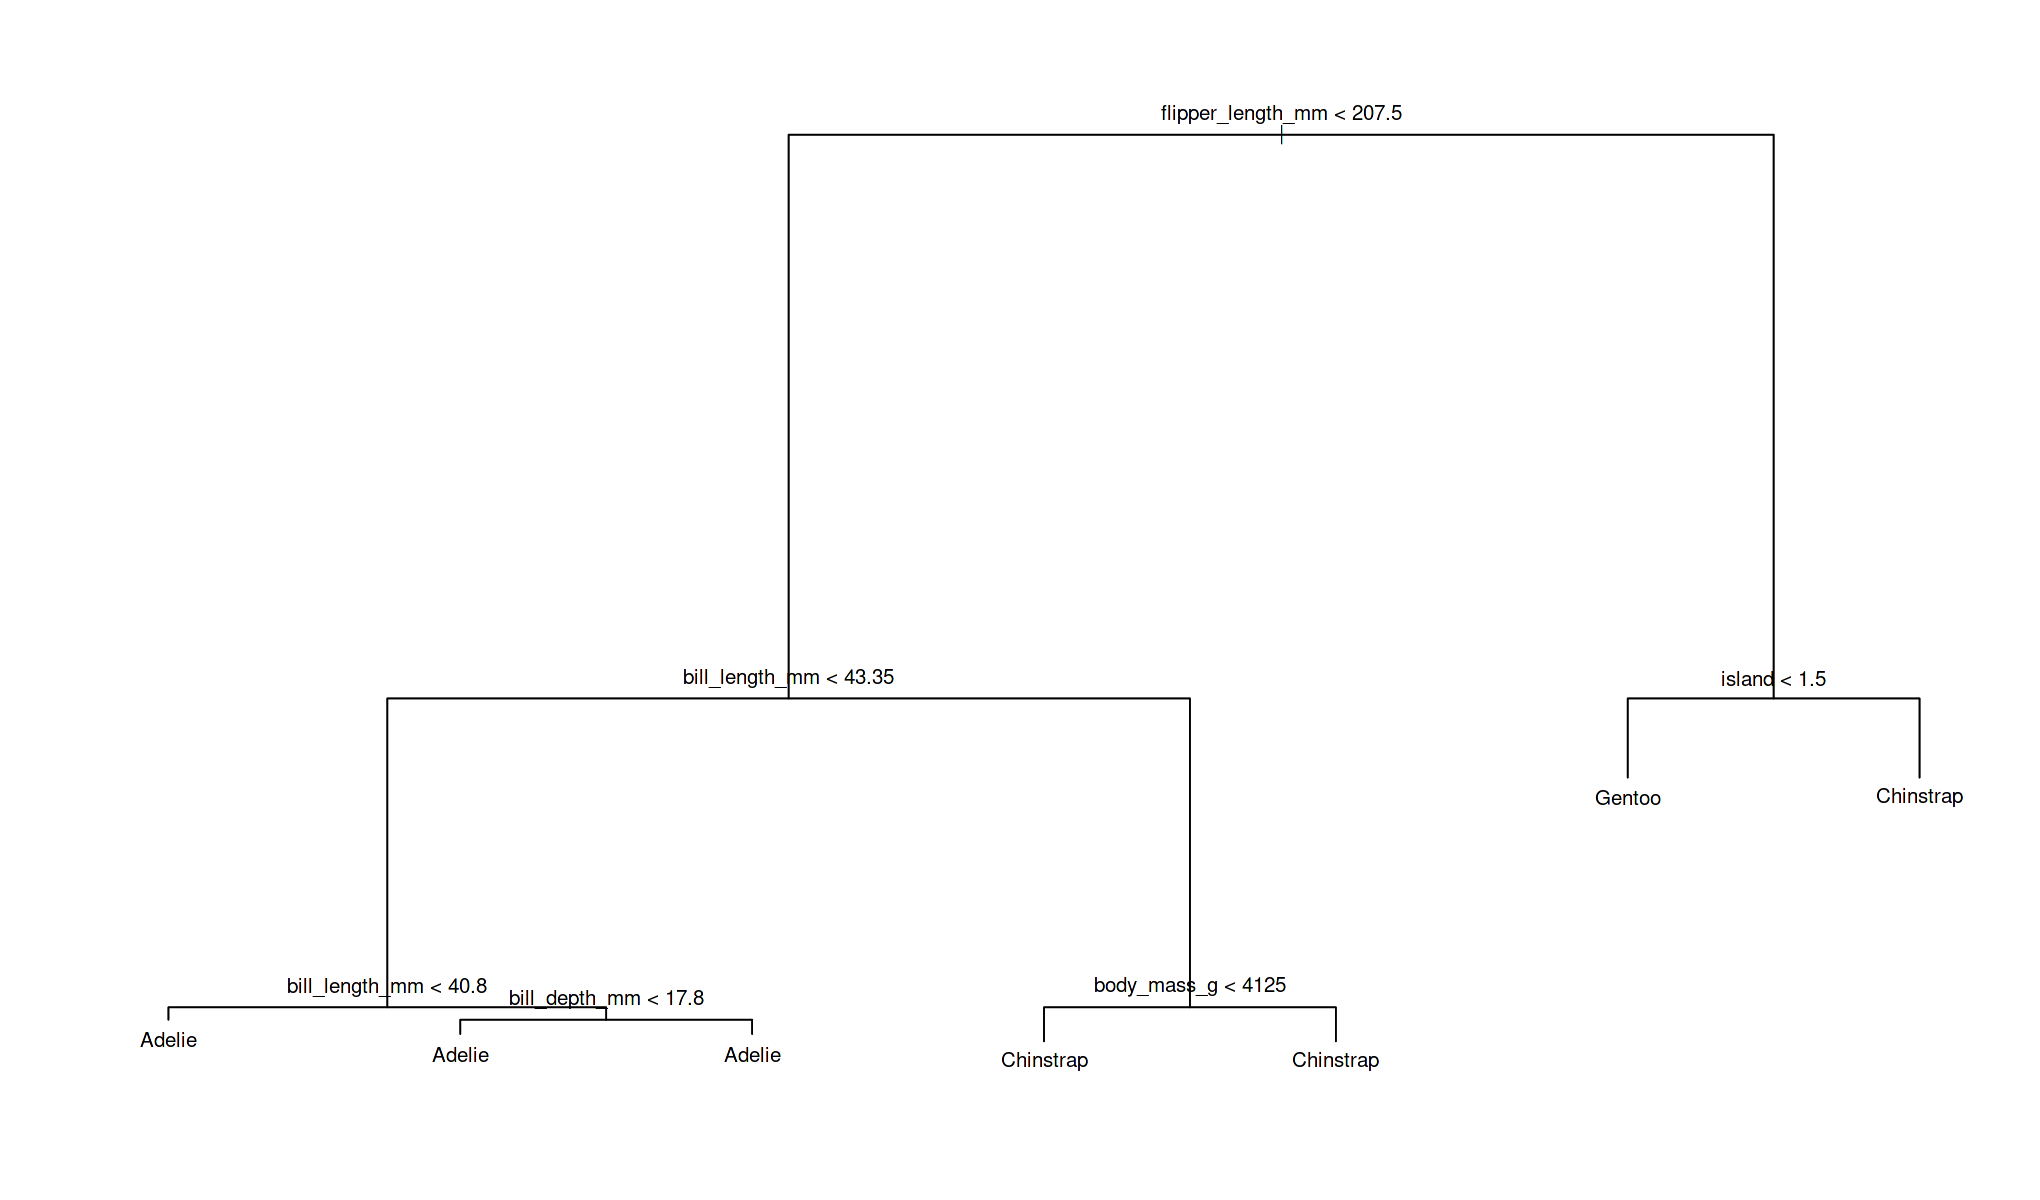

In [9]:
decision_tree <- tree(species ~ ., data = dataset)
# decision_tree
# summary(decision_tree)

plot(decision_tree)
text(decision_tree, pretty = 0)

## 3.2 RFECV
#### From the RFECV, we see that it matches well with our decision trees, i.e., sex and year are not very important for the model.

In [10]:
control <- trainControl(method="repeatedcv", number=10, repeats=3)
model <- train(species~., data=dataset, method="rf", preProcess="scale", trControl=control)
importance <- varImp(model, scale=FALSE)
print(importance)

rf variable importance

                  Overall
bill_length_mm    55.0203
flipper_length_mm 38.2715
bill_depth_mm     26.2720
body_mass_g       18.7257
island            18.5833
sex                1.2222
year               0.8982


# 4. Modelling

## 4.1 Full model

In [11]:
classifier <- randomForest(species ~., data = dataset, importance = T) 
predicted_table <- predict(classifier,
                           validation[,x_loc])
table(observed = validation[,Y_loc], predicted = predicted_table)

           predicted
observed    Adelie Chinstrap Gentoo
  Adelie        36         0      0
  Chinstrap      1        16      0
  Gentoo         0         0     29

## 4.2 Reduced model

#### In the reduced model, we don't use the features sex and years.

In [12]:
vars = c(1,3,4,5,6)
vars2 = c(3,4,5,6)
classifier <- randomForest(species ~., data = dataset[vars],importance = T,
                          maxnodes = 11, ntree = 500) 

predicted_table <- predict(classifier,
                           validation[,vars2])
table(observed = validation[,Y_loc], predicted = predicted_table)


           predicted
observed    Adelie Chinstrap Gentoo
  Adelie        36         0      0
  Chinstrap      2        15      0
  Gentoo         0         0     29

## 4.3 Further reduced model

#### If we reduce the model further, to only bill length and bill depth, we observe that we still get a pretty good model, with only 1 more misclassification.

           predicted
observed    Adelie Chinstrap Gentoo
  Adelie        35         1      0
  Chinstrap      2        15      0
  Gentoo         0         3     26

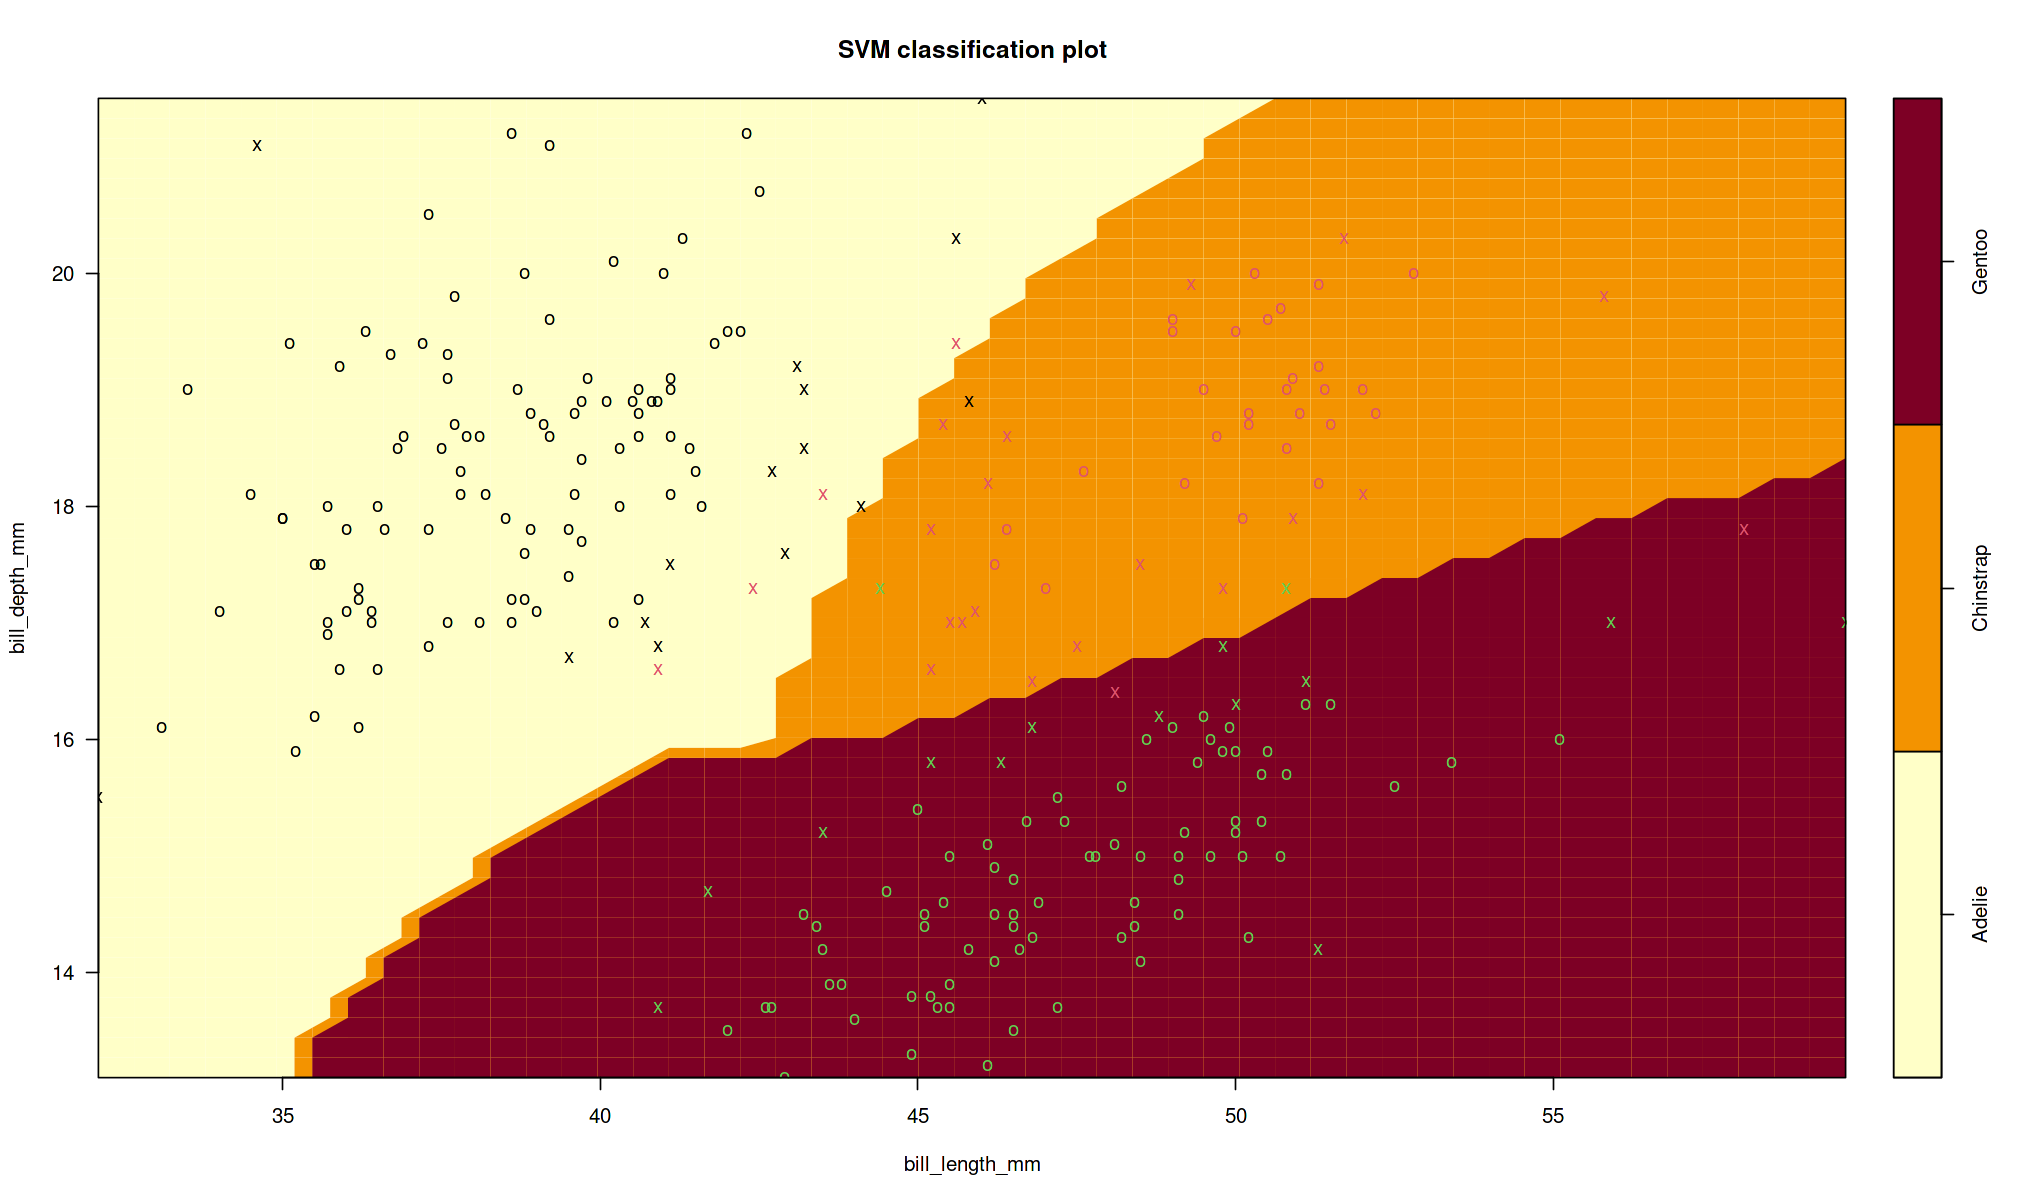

In [13]:
vars = c(1,3,4)
vars2 = c(3,4)

classifier <- randomForest(species ~., data = dataset[vars],importance = T,
                          maxnodes = 11, ntree = 500) 
predicted_table <- predict(classifier,
                           validation[,vars2])
table(observed = validation[,Y_loc], predicted = predicted_table)

svm_model <- svm(species ~ ., data=dataset[vars],
                 kernel="radial") 
plot(svm_model, data=dataset[vars],
     bill_depth_mm~bill_length_mm)